# 今日任务：图像聚类

1. 给定的图像数据集，可视化并输出聚类性能

In [62]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from utils.os import get_root_path

def evaluate_clusters(X, y, n_neighbors=2):
    """
    K-means 聚类计算 ACC, NMI, ARI
    """
    # 创建 KNN 聚类模型
    knn = KNN(n_neighbors=n_neighbors)
    knn.fit(X, y)
    
    # 预测聚类标签
    y_knn = knn.predict(X)
    
    # 计算 ACC, NMI, ARI
    acc = np.mean(y_knn == y)
    nmi = normalized_mutual_info_score(y, y_knn)
    ari = adjusted_rand_score(y, y_knn)
    return acc, nmi, ari

def kmeans_clustering_image(image, k):
    """
    对图像进行 k-means 聚类
    
    Returns:
        k-means 聚类后的图像
    """
    rows, cols, channels = image.shape
    image_2d = image.reshape(rows * cols, channels)
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(image_2d)
    clustered = kmeans.cluster_centers_[kmeans.labels_]
    clustered = clustered.reshape(rows, cols, channels) 
    return clustered / 255.0


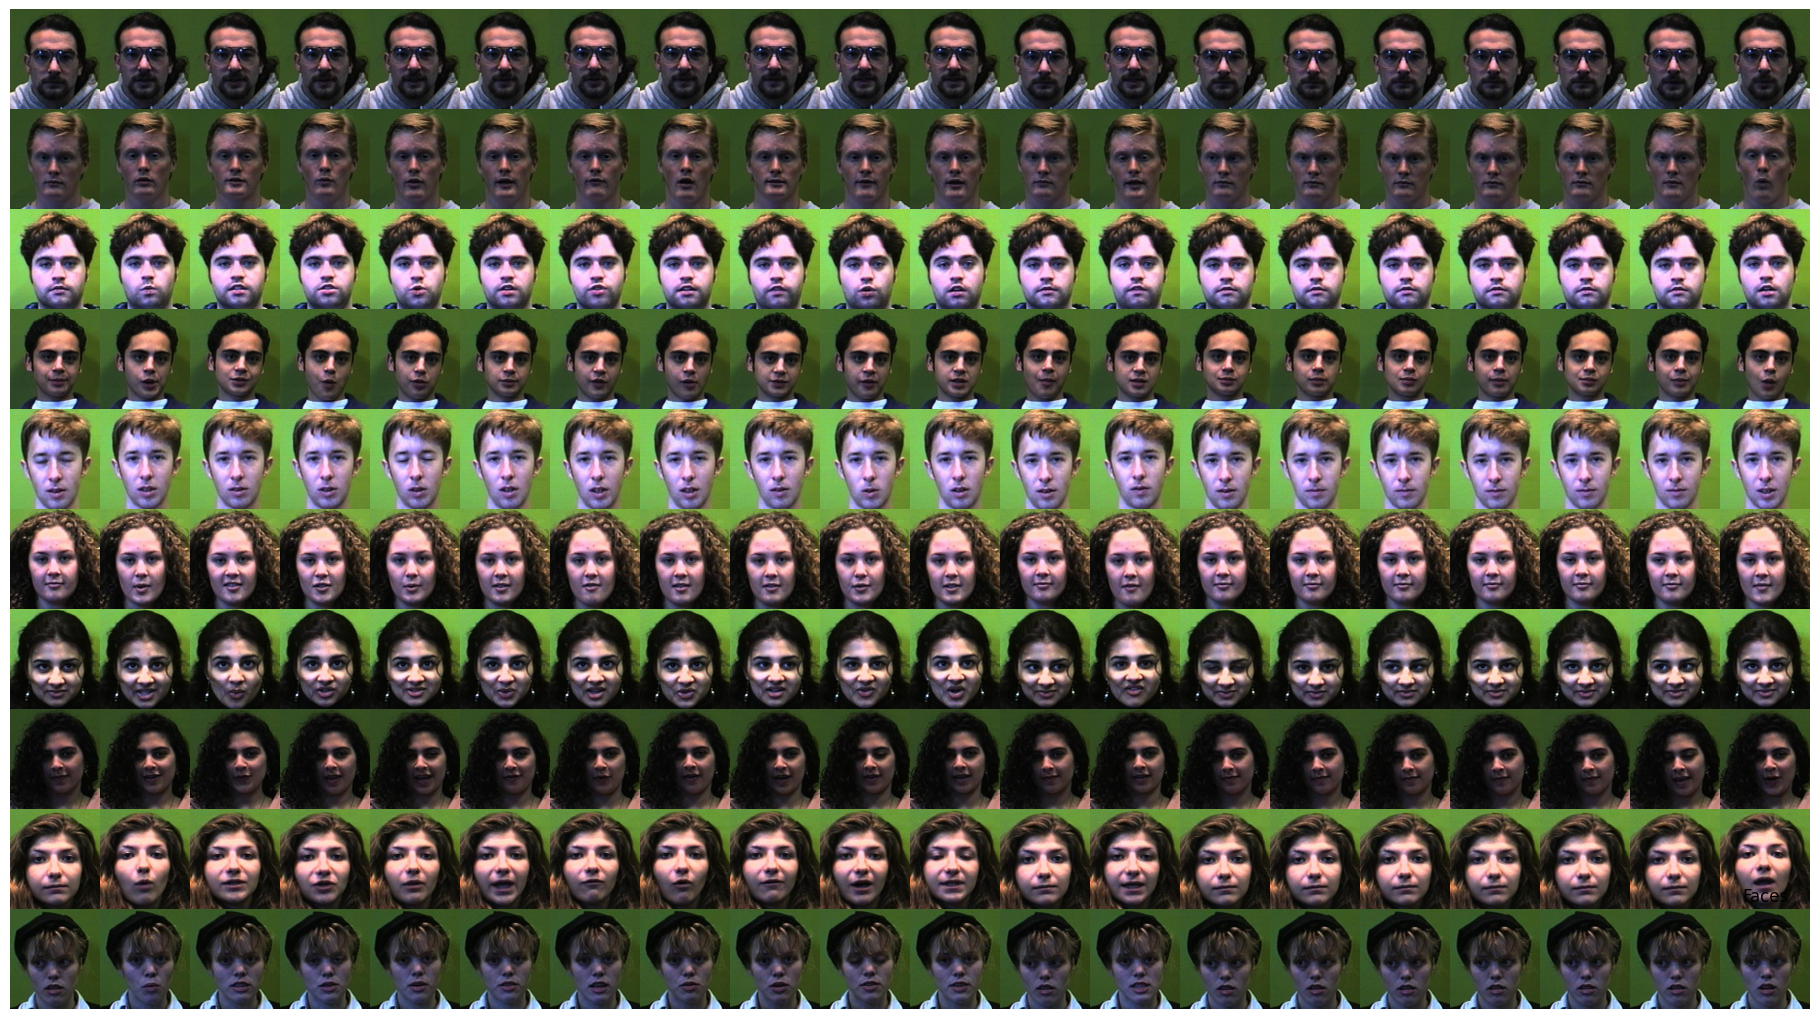

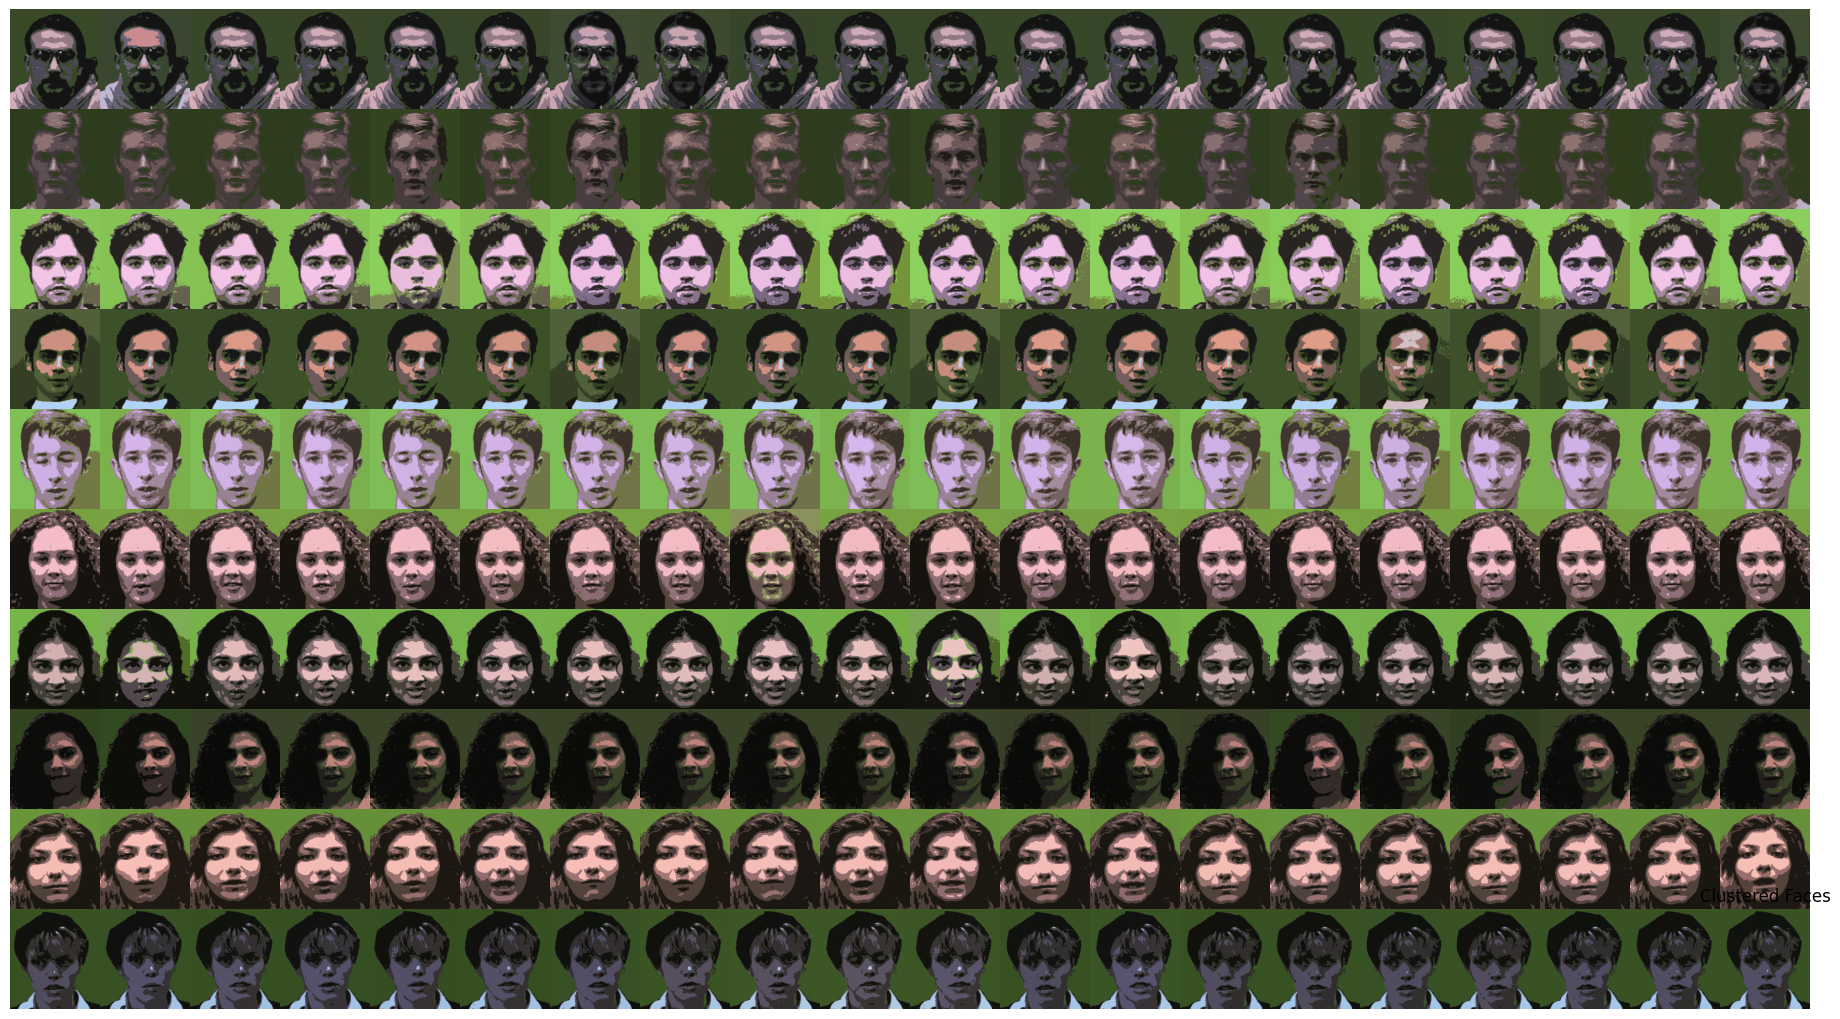

In [82]:
# 文件结构：
# datas/Ch4-data/face_images/
# ├── admars
#     ├── admars.1.jpg
#     ├── ...
#     └── admars.20.jpg
# ├── ahodki
#     ├── ahodki.1.jpg
#     ├── ...
#     └── ahodki.20.jpg
# ├── ...
# └── drbost
#     ├── drbost.1.jpg
#     ├── ...
#     └── drbost.20.jpg
# 其中每个文件下的图片都有 20 张
# 读取并可视化本地路径 datas/Ch4-data/face_images 下所有图片的数据集

# 读取本地路径下的所有图片
image_root = f'{get_root_path()}/datas/Ch4-data/face_images/'
image_dir_list = os.listdir(image_root)
n_faces = len(image_dir_list)  # 人脸种类数
n_clusters = 5

# 获取其中一个图像的大小作为统一的显示大小
# noinspection PyShadowingNames
def get_fig_size(image_root):
    dir_path = os.path.join(image_root, image_dir_list[0])
    image_path = os.path.join(dir_path, os.listdir(dir_path)[0])
    image = cv2.imread(image_path)
    image_size = image.shape[:2]
    fig_size = (20 * image_size[1] / 200, n_faces * image_size[0] / 200)
    return fig_size, image_size
fig_size, image_size = get_fig_size(image_root)

# 显示图片的密集排布形式
fig, axes = plt.subplots(n_faces, 20, figsize=fig_size)
fig_clustered, axes_clustered = plt.subplots(n_faces, 20, figsize=fig_size)
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1)
fig_clustered.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1)
for i, image_dir_name in enumerate(image_dir_list):
    image_dir = os.path.join(image_root, image_dir_name)
    image_list = os.listdir(image_dir)
    for j, image_name in enumerate(image_list):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 显示原始图像
        axes[i][j].imshow(img)
        axes[i][j].axis('off')
        
        # 显示聚类图像
        clustered_image = kmeans_clustering_image(img, n_clusters)
        axes_clustered[i][j].imshow(clustered_image)
        axes_clustered[i][j].axis('off')

plt.show()


In [64]:

# 从文件中读取图片，生成聚类数据集
X = []
y = []
for i, image_dir_name in enumerate(image_dir_list):
    image_dir = os.path.join(image_root, image_dir_name)
    image_list = os.listdir(image_dir)
    for j, image_name in enumerate(image_list):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)
        y.append(i)

# 转换数据集为 numpy 数组
X = np.array([X[i].flatten() for i in range(len(X))])
y = np.array(y)

# 输出聚类性能
acc, nmi, ari = evaluate_clusters(X, y, n_neighbors=n_faces)
print(f"ACC: {acc * 100:.2f}%, NMI: {nmi:.4f}, ARI: {ari:.4f}")


ACC: 100.00%, NMI: 1.0000, ARI: 1.0000


# 今日任务：图像特征脸

2. 给定的图像数据集，计算相应的特征脸（eigenfaces）

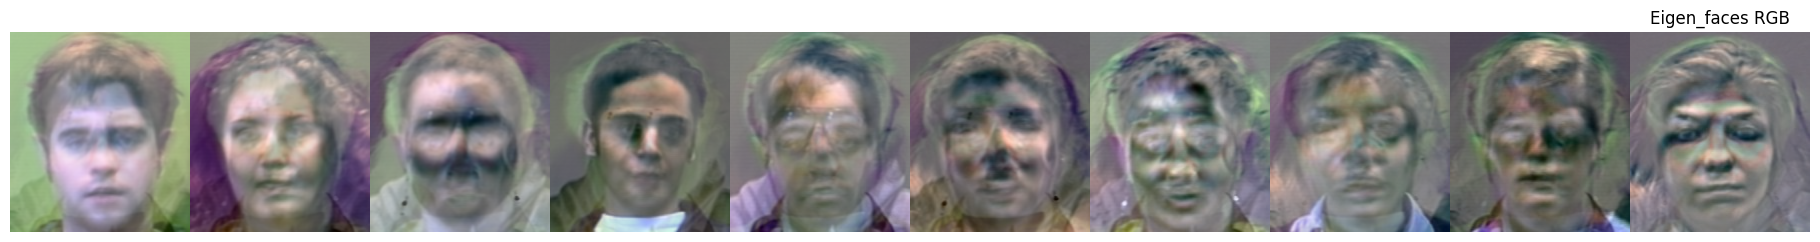

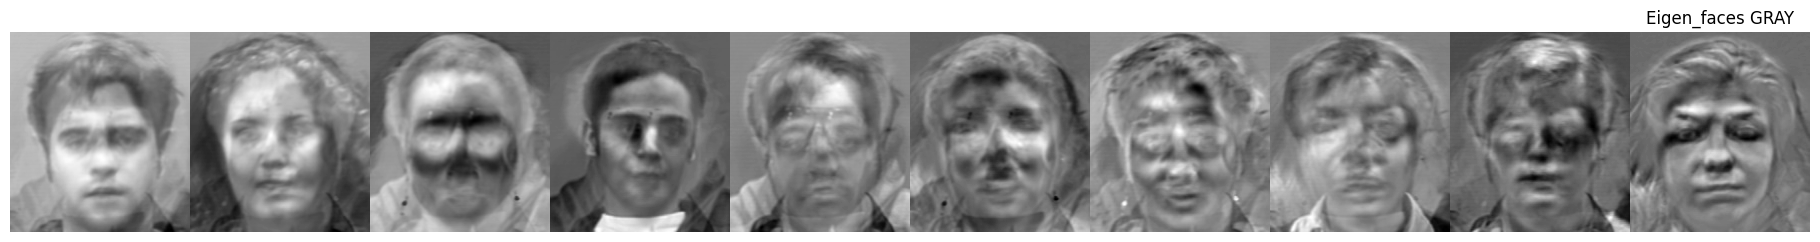

In [96]:

# 特征脸计算
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

n_clusters = n_faces
image_shape = (*image_size, 3)

# 获取图像特征
image_features = []
for i, image_dir_name in enumerate(image_dir_list):
    image_dir = os.path.join(image_root, image_dir_name)
    image_list = os.listdir(image_dir)
    
    for j, image_name in enumerate(image_list):
        image_path = os.path.join(image_dir, image_name)
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        
        image_features.append(image.flatten())
    
# 转换数据集为 numpy 数组
X = np.array(image_features)

# 计算特征脸
pca = PCA(n_components=n_clusters)
X_pca = pca.fit_transform(X)

# 提取主成分
components = pca.components_
eigen_faces = []
for i in range(len(components)):
    eigen_face = components[i]
    eigen_face = (eigen_face - np.min(eigen_face)) / (np.max(eigen_face) - np.min(eigen_face))
    eigen_faces.append(eigen_face.reshape(image_shape))

# RGB 特征脸
fig, axes = plt.subplots(1, n_clusters, figsize=fig_size)
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1)
for i, eigen_face in enumerate(eigen_faces):
    axes[i].imshow(eigen_face)
    axes[i].axis('off')
plt.title('Eigen_faces RGB')

# 灰度特征脸
fig, axes = plt.subplots(1, n_clusters, figsize=fig_size)
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0, top=1)
for i, eigen_face in enumerate(eigen_faces):
    eigen_face = (eigen_face * 255).astype(np.uint8)
    eigen_face = cv2.cvtColor(eigen_face, cv2.COLOR_RGB2GRAY)
    axes[i].imshow(eigen_face, cmap='gray')
    axes[i].axis('off')
plt.title('Eigen_faces GRAY')

plt.show()

# 今日任务：图像降维

3. 给定的图像数据集，探讨 PCA 降维后特征个数与聚类性能的关系

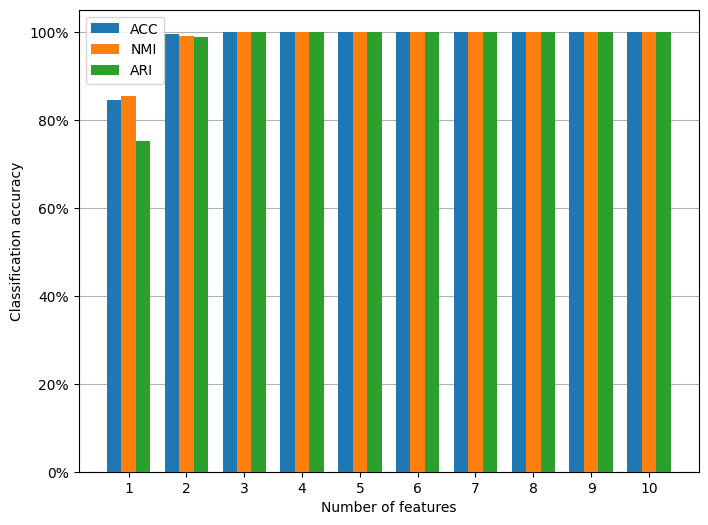

In [69]:

# 图像降维
from sklearn.decomposition import PCA


def PCA_KNN(n_components=5):
    """
    PCA 降维后 KNN 聚类计算 ACC, NMI, ARI
    """
    # 使用 PCA 降维
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # 输出聚类性能
    return evaluate_clusters(X_pca, y, n_neighbors=n_faces)
    

# 记录所有聚类性能参数
acc_list = []
nmi_list = []
ari_list = []
component_list = [i for i in range(1, 11)]
# 计算聚类性能参数
for n_components in component_list:
    acc, nmi, ari = PCA_KNN(n_components=n_components)
    acc_list.append(acc)
    nmi_list.append(nmi)
    ari_list.append(ari)

# 绘制柱状图
plt.figure(figsize=(8, 6))

# 设置刻度、标签和显示范围
plt.xlabel('Number of features')
plt.ylabel('Classification accuracy')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x * 100:.0f}%"))
plt.xticks(component_list)
plt.grid(axis='y')

# 绘制三条柱状图
width = 0.25
x_acc = np.array(component_list) - width
x_nmi = np.array(component_list)
x_ari = np.array(component_list) + width
plt.bar(x_acc, acc_list, width=width, label='ACC', zorder=3)
plt.bar(x_nmi, nmi_list, width=width, label='NMI', zorder=3)
plt.bar(x_ari, ari_list, width=width, label='ARI', zorder=3)

# 显示图例
plt.legend()

# 显示图像
plt.show()
